# 150줄로 된 간단한 네트워크Simple network with 150 lines

metamath1/ml-simple-works 저장소에서 바로 보고 있다면 예쁘게 랜더링해서 보기 : http://nbviewer.jupyter.org/github/metamath1/ml-simple-works/blob/master/simplenet/simplenet.ipynb
<hr/>

여기에서는 아주 간단한 네트워크를 직접 구현해 보는 것을 목표로 한다. 
Nielsen문서<a href="http://neuralnetworksanddeeplearning.com/chap1.html">[1]</a>나 다른 문서들을 보면서 이론을 이해했으면 그 문서에서 제공하는 코드를 보게 되는데 아무래도 각 층을 객체지향적으로 구현하다보니 소스가 좀 복잡하다고 느껴진다. 특히 역전파같은 경우는 객체지향적으로 구현하기에 매우 적합한 구조라 생각하지만 모르는 입장에서는 막상 구현된 결과를 보면 조각조각 쪼개져 있어서 전체적인 그림을 그리기 힘들다는 단점이 있다. 그런 이유로 객체지향 구현보다 더 간단하지만(적어도 내가 생각하기에는) 비슷한 성능을 내는 코드를 처음부터 구현하면서 간단한 뉴럴네트워크에 대한 이해도를 높이려고 하였다.<br/>
따라서 코드는 절차지향적으로 작성되었으며 Network을 정의하는 부분만 Class를 사용하였다. 나머지는 모두 데이터가 입력되고 웨이트와 곱해지고 하는 네트워크의 절차적 흐름을 최대한 가독성 높게 구현하려고 하였다.

## 1. 구현 요구 사항
<hr/>

- 당연히 Numpy로만 구현

- 최대한 간단하게 150줄 내외로 구현해서 언제나 봐도 30분안에 이해되도록

- Nielsen 문서의 수식 인덱스와 구현된 파이썬 인덱스를 완전히 일치시킴. 즉 다음 기본 식 4개의 인덱스와 파이썬 프로그램 배열의 인덱스를 완전히 일치시켜서 프로그램 하여 가독성을 최대화 함.

$$\delta^{L}_{j}= \frac{\partial C}{\partial a^{L}_{j}} \sigma^{'}(z^{L}_{j})$$

$$\delta^{l}_{j} = \sum_{k} w^{l+1}_{kj} \delta^{l+1}_{k}   \sigma^{'}(z^{k}_{j}) $$

$$\frac{\partial C}{\partial b^{l}_{j}} = \delta^{l}_{j}$$

$$\frac{\partial C}{\partial w^{l}_{jk}} = a^{l-1}_{k} \delta^{l}_{j}$$

- 완전 연결층만 구현

- 코스트 함수 : Mean Square Error, Binary Cross Entropy, Categorical Cross Entropy

- 활성 함수 : Sigmoid, Relu, Softmax

- 기타 구현 : Regularization, Dropout, Batch Normalization\*

- 테스트데이터 : MNIST

\* 은 선택사항


## 2. 구현 세부 사항
<hr/>

구현에 있어서 가장 어려운 부분은 

$$\delta^{L}_{j}= \frac{\partial C}{\partial a^{L}_{j}} \sigma^{'}(z^{L}_{j})$$

을 구현하는 부분인데 왜냐하면 코스트 함수와 출력층의 활성화 함수를 직접 미분해서 코딩해야하기 때문이다. 보통은 $\boldsymbol{\delta}^{L}$을 구하기 위해 위 식을 그대로 코딩하지는 않고 위 식이 계산된 결과를 코딩하게 된다. 수치 안정성이나 코딩의 양이 적어 훨씬 효율적이기 때문이다. 구현에 사용되는 sigmoid, softmax와 mean square error, cross entropy함수를 적당히 잘 조합하면 $\boldsymbol{\delta}^{L} = \mathbf{a}-\mathbf{y}$가 되어 간단하게 코딩할 수 있는데 여기서는 학습의 목적으로 코스트함수와 활성화 함수를 직접 다 미분해서 구현하였다. 때문에 원하는대로 출력층 활성화 함수와 코스트함수를 마음대로 조합해가며 실험할 수 있다. 예를 들어 sigmoid-cross entropy 같은 조합도 가능한데 이렇게 하면 코스트함수가 sigmoid 출력의 특성을 잘 반영하지 못하기 때문에 학습이 안되는 결과를 확인할 수 있다.

전체적인 구성은 다음과 같이 활성함수와 코스트함수를 함수값 계산, 미분값 계산을 하는 두 부분으로 구현하고 각각을 'f', 'df'를 키로 하는 사전으로 묶어 둔다.

```python
#--------------------------------------------------------------------
# activation functions
# 활성함수의 함수값을 계산하는 함수와 미분값을 계산하는 함수를 한쌍으로 정의
# 'f'와 'df' 키워드로 묶음
def sigmoid(z):
    """
    z : (C, N), C:클래스 수, N:샘플 수 이하 동일
    """
    return 1.0/(1.0+np.exp(-z))
 
def sigmoid_prime(z, y):
    """
    z : (C, N)
    y : dummy
    
    [참고]
    여기서는 정답 벡터 y가 필요없지만 softmax_prime_with_crossent과 인터페이스를 맞추기 위해
    더미로 y를 넘겨 받음 None로 넘겨주면 됨.
    """ 
    return sigmoid(z)*(1-sigmoid(z))
    
Sigmoid = { 'f': sigmoid, 'df': sigmoid_prime }

#--------------------------------------------------------------------
# Cost function
# 목적함수의 함수값을 계산하는 함수와 미분값을 계산하는 함수를 한쌍으로 정의
# 'f'와 'df' 키워드로 묶음
def mse_cost(a, y):
    """
    a : (C, N)
    y : col major로 인코딩된 one hot (C, N)
    """
    return 0.5*np.linalg.norm(a-y)**2

def mse_cost_prime(a, y):
    """
    a : (C, N)
    y : col major로 인코딩된 one hot (C, N)
    """
    return (a-y)

Mse = {'f':mse_cost, 'df':mse_cost_prime}
```

이렇게 구현해두면 필요한 것만 골라서 조합해서 네트워크를 구성할 수 있게 된다. 프로그램의 구조는 위 코드가 핵심이며 다른건 별게 없다.


### 2.1 Cross Entropy Cost and Softmax 

다른 부분은 주석이 자세하게 달려 있어서 문서로는 cross entropy를 코스트함수로 쓰고 출력층 활성화함수를 softmax로 할 때 미분 관련해서만 남긴다. 네트워크를 학습시키기 위한 목적함수(또는 코스트,  로스함수)는 스칼라함수이고 sigmoid, tanh 함수같은 경우 역시 스칼라 함수이므로 둘다 미분을 해서 곱하기에 무리가 없다.  $\boldsymbol{\delta}^{L}$을 구하기 위한 다음 식을 보면

$$\delta^{L}_{cn}= \frac{\partial C}{\partial a^{L}_{cn}} \frac{d \sigma(z^{L}_{cn})}{d z^{L}_{cn}}$$

인데 이 식에서 $c$는 $L$층의 뉴런 인덱스이고 $n$는 샘플의 인덱스이다. 그렇게 보면 위 식의 $\delta^{L}_{cn}$은 행렬, $\dfrac{\partial C}{\partial a^{L}_{cn}}$도 행렬이고, sigmoid, tanh같은 함수를 $\sigma$로 썼다면 $\dfrac{d \sigma(z^{L}_{cn})}{d z^{L}_{cn}}$ 역시 행렬이 되어 두 행렬 $\dfrac{\partial C}{\partial \mathbf{a}^{L}}$와 $\dfrac{d \sigma(\mathbf{z}^{L})}{ d \mathbf{z}^{L}}$를 element-wise하게 곱하면 된다. <br/>
하지만 softmax함수는 $\mathbb{R}^{c} \to \mathbb{R}^{c}$인 벡터함수로 입력벡터 $\mathbf{z}^{L}$로의 미분이 자코비안 행렬이 된다. 샘플의 개수가 $N$개라면 이런 행렬이 $N$개가 있는 $N \times C \times C$인 텐서(정확히는 3차원 어레이)가 된다. 그래서 위 식을 처리할때 약간 주의를 해야한다. 단계적으로 정리를 한다.



#### 2.1.1 Cost 함수 미분

Cross Entropy 코스트의 정의는 아래와 같다.

$$\text{C}= - \sum_{C} y_{c} \log a_{c}\equiv - \log a_{y} $$

이 식에서 $C$는 클래스의 수를 나타낸다. $y_c$는 크기 $C \times 1$ 원핫벡터인 $\mathbf{y}$의 $c$번째 요소를 나타내고 마지막 $a_{y}$는 출력 $a$중에 $y$번째 값을 나타낸다. 여기서 $y$는 원핫인코딩 되지 않은 0, 1, 2, 3, 4, 5, 6, 7, 8, 9의 값을 가지는 정답 숫자이다. N개의 샘플에 대한 네트워크의 마지막 층에서 가중합과 softmax에 의한 출력은 각각 다음과 같다. 인덱스 순서는 앞의 인덱스가 클래스 번호, 뒤에 인덱스가 샘플번호이다.

$$
\begin{bmatrix}
z_{11} & z_{12} & \cdots & z_{1N} \\[4pt]
z_{21} & z_{22} & \cdots & z_{2N} \\[4pt]
z_{31} & z_{32} & \cdots & z_{3N} \\[4pt]
\vdots & \vdots & \ddots & \vdots \\
z_{C1} & z_{C2} & \cdots & z_{CN} 
\end{bmatrix}
\xrightarrow{\text{softmax}}
\begin{bmatrix}
a_{11} & a_{12} & \cdots & a_{1N} \\[4pt]
a_{21} & a_{22} & \cdots & a_{2N} \\[4pt]
a_{31} & a_{32} & \cdots & a_{3N} \\[4pt]
\vdots & \vdots & \ddots & \vdots \\
a_{C1} & a_{C2} & \cdots & a_{CN} 
\end{bmatrix}
$$

그러면 이 코스트에 대한 미분은 다음과 같다.

$$\frac{\partial \, \text{C}}{\partial \, \mathbf{a}} = 
\begin{bmatrix}
\dfrac{\partial \, \text{C}}{\partial a_{11}} & \dfrac{\partial \, \text{C}}{\partial a_{12}}& \cdots & \dfrac{\partial \, \text{C}}{\partial a_{1N}} \\[4pt]
\dfrac{\partial \, \text{C}}{\partial a_{21}} & \dfrac{\partial \, \text{C}}{\partial a_{22}}& \cdots & \dfrac{\partial \, \text{C}}{\partial a_{2N}} \\[4pt]
\dfrac{\partial \, \text{C}}{\partial a_{31}} & \dfrac{\partial \, \text{C}}{\partial a_{32}}& \cdots & \dfrac{\partial \, \text{C}}{\partial a_{3N}} \\[4pt]
\vdots & \vdots & \ddots & \vdots \\
\dfrac{\partial \, \text{C}}{\partial a_{C1}} & \dfrac{\partial \, \text{C}}{\partial a_{C2}}& \cdots & \dfrac{\partial \, \text{C}}{\partial a_{CN}} \\
\end{bmatrix}
$$

그런데 코스트함수의 정의상 정답자리를 제외한 대부분의 위치는 0 이다. 예를 들어 $y_{21}$, $y_{32}$, $y_{CN}$등이 정답자리(바꿔 말하면 1번 샘플은 2, 2번 샘플은 3, ...)라고 하면

$$
\frac{\partial \, \text{C}}{\partial \, \mathbf{a}} = 
\begin{bmatrix}
\dfrac{\partial \, \text{C}}{\partial a_{11}} & \dfrac{\partial \, \text{C}}{\partial a_{12}}& \cdots & \dfrac{\partial \, \text{C}}{\partial a_{1N}} \\[4pt]
\dfrac{\partial \, \text{C}}{\partial a_{21}} & \dfrac{\partial \, \text{C}}{\partial a_{22}}& \cdots & \dfrac{\partial \, \text{C}}{\partial a_{2N}} \\[4pt]
\dfrac{\partial \, \text{C}}{\partial a_{31}} & \dfrac{\partial \, \text{C}}{\partial a_{32}}& \cdots & \dfrac{\partial \, \text{C}}{\partial a_{3N}} \\[4pt]
\vdots & \vdots & \ddots & \vdots \\
\dfrac{\partial \, \text{C}}{\partial a_{C1}} & \dfrac{\partial \, \text{C}}{\partial a_{C2}}& \cdots & \dfrac{\partial \, \text{C}}{\partial a_{CN}} \\
\end{bmatrix}
=
\begin{bmatrix}
0 & 0 & \cdots & 0 \\[4pt]
-\dfrac{1}{a_{21}} & 0 & \cdots & 0 \\[4pt]
0 & -\dfrac{1}{a_{32}} & \cdots & 0 \\[4pt]
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & -\dfrac{1}{a_{CN}} \\
\end{bmatrix}
$$

와 같이 미분한 행렬이 완성된다. python 코드로는 다음처럼 구현할 수 있다. 이때 출력 $a$가 softmax로부터의 출력일 경우 $a$가 거의 0일 수 있기때문에 오버플로 방지대책을 세워준다.

```python
def cross_entropy_cost_prime(a, y):
    dC = np.zeros(a.shape)
    a[np.where(a < np.finfo(np.float32).eps)] = np.finfo(np.float32).eps
    dC[np.where(y ==1)] = -y[np.where(y==1)]/a[np.where(y==1)]
    
    return dC  #(C,N)
```

#### 2.1.2 Softmax 함수 미분

샘플 $\mathbf{x}_{1}$에 대한 softmax함수의 미분은 다음과 같다.

$$\frac{\partial \, \mathbf{a}_{\mathbf{x}_{1}}}{\partial \, \mathbf{z}_{\mathbf{x}_{1}}} = 
\begin{bmatrix}
\dfrac{\partial \, a_{11}}{\partial z_{11}} & \dfrac{\partial \, a_{11}}{\partial z_{21}}& \cdots & \dfrac{\partial \, a_{11}}{\partial z_{C1}} \\[4pt]
\dfrac{\partial \, a_{21}}{\partial z_{11}} & \dfrac{\partial \, a_{21}}{\partial z_{21}}& \cdots & \dfrac{\partial \, a_{21}}{\partial z_{C1}} \\[4pt]
\dfrac{\partial \, a_{31}}{\partial z_{11}} & \dfrac{\partial \, a_{31}}{\partial z_{21}}& \cdots & \dfrac{\partial \, a_{31}}{\partial z_{C1}} \\[4pt]
\vdots & \vdots & \ddots & \vdots \\
\dfrac{\partial \, a_{C1}}{\partial z_{11}} & \dfrac{\partial \, a_{C1}}{\partial z_{21}}& \cdots & \dfrac{\partial \, a_{C1}}{\partial z_{C1}} \\
\end{bmatrix}
$$

실제 softmax의 미분은 다음과 같으므로 [https://www.facebook.com/groups/TensorFlowKR/permalink/502663916741338/]

$$
\frac{\partial \, \text{softmax}(z_{j})}{\partial \, z_{i}}=
\begin{cases}
\text{softmax}(z_{j})(1-\text{softmax}(z_{i})), & \mbox{if } j=i \\
-\text{softmax}(z_{j})\text{softmax}(z_{i}) , & \mbox{if } j \neq i
\end{cases}
$$

샘플 $\mathbf{x}_{1}$에 대한 softmax함수의 미분이 아래처럼 완성된다.

$$\frac{\partial \, \mathbf{a}_{\mathbf{x}_{1}}}{\partial \, \mathbf{z}_{\mathbf{x}_{1}}} = 
\begin{bmatrix}
\dfrac{\partial \, a_{11}}{\partial z_{11}} & \dfrac{\partial \, a_{11}}{\partial z_{21}}& \cdots & \dfrac{\partial \, a_{11}}{\partial z_{C1}} \\[4pt]
\dfrac{\partial \, a_{21}}{\partial z_{11}} & \dfrac{\partial \, a_{21}}{\partial z_{21}}& \cdots & \dfrac{\partial \, a_{21}}{\partial z_{C1}} \\[4pt]
\dfrac{\partial \, a_{31}}{\partial z_{11}} & \dfrac{\partial \, a_{31}}{\partial z_{21}}& \cdots & \dfrac{\partial \, a_{31}}{\partial z_{C1}} \\[4pt]
\vdots & \vdots & \ddots & \vdots \\
\dfrac{\partial \, a_{C1}}{\partial z_{11}} & \dfrac{\partial \, a_{C1}}{\partial z_{21}}& \cdots & \dfrac{\partial \, a_{C1}}{\partial z_{C1}} \\
\end{bmatrix}
=
\begin{bmatrix}
a_{11}(1-a_{11}) & -a_{11}a_{21} & \cdots & -a_{11}a_{C1} \\[4pt]
-a_{21}a_{11} & a_{21}(1-a_{21}) & \cdots & -a_{21}a_{C1} \\[4pt]
-a_{31}a_{11} & -a_{31}a_{21} & \cdots & -a_{31}a_{C1} \\[4pt]
\vdots & \vdots & \ddots & \vdots \\
-a_{C1}a_{11} & -a_{C1}a_{21} & \cdots & a_{C1}(1-a_{C1})
\end{bmatrix}
$$

이렇게 샘플 $\mathbf{x}_{n}$에 대해 하나의 미분 행렬이 주어지므로 최종 결과는 $N \times C \times C$인 텐서가 된다.

```python
def softmax_prime(z, y):
    C, N = z.shape
    di = np.diag_indices(C)
    
    a = softmax(z) # a : (C,N)
    da = -np.einsum('ij,jk->jik', a, a.T)  #da :(N,C,C)
    da[:,di[0],di[1]] = (a*(1-a)).T
    
    return da
```

이제 코스트함수의 미분 softmax함수의 미분이 끝났으므로 이 둘을 곱해서 $\boldsymbol{\delta}^{L}$을 만들어야 한다.  $\boldsymbol{\delta}^{L}$의 크기는 샘플 1개당 $C \times 1$짜리 벡터가 모여있는 것이므로 $C \times N$이 된다. 샘플 $\mathbf{x}_{1}$에 대한 $\boldsymbol{\delta}_{\mathbf{x}_{1}}^{L}$은 다음처럼 계산할 수 있다.

$$
\begin{align}
\left( \boldsymbol{\delta}_{\mathbf{x}_{1}}^{L} \right)^{\text{T}} &= 
\begin{bmatrix}
0 & -\dfrac{1}{a_{21}} & 0 & \cdots & 0 \\
\end{bmatrix}
\frac{\partial \, \mathbf{a}_{\mathbf{x}_{1}}}{\partial \, \mathbf{z}_{\mathbf{x}_{1}}} \\[5pt]
&= 
\underbrace{
\begin{bmatrix}
0 & -\dfrac{1}{a_{21}} & 0 & \cdots & 0 \\
\end{bmatrix}
}_{ \dfrac{\partial C}{\partial a^{L}_{c1}} }
\underbrace{
\begin{bmatrix}
a_{11}(1-a_{11}) & -a_{11}a_{21} & \cdots & -a_{11}a_{C1} \\[4pt]
-a_{21}a_{11} & a_{21}(1-a_{21}) & \cdots & -a_{21}a_{C1} \\[4pt]
-a_{31}a_{11} & -a_{31}a_{21} & \cdots & -a_{31}a_{C1} \\[4pt]
\vdots & \vdots & \ddots & \vdots \\
-a_{C1}a_{11} & -a_{C1}a_{21} & \cdots & a_{C1}(1-a_{C1})
\end{bmatrix}
}_{ \dfrac{\partial \, \mathbf{a}_{\mathbf{x}_{1}}}{\partial \, \mathbf{z}_{\mathbf{x}_{1}}} }
\end{align}
$$

위 식의 첫항은 코스트함수 $\text{C}$를 $a_{c1}$로 미분한 것으로 $\dfrac{\partial \, \text{C}}{\partial \, \mathbf{a}}$의 첫번째 열이 된다. 이런 계산을 샘플 $\mathbf{x}$에 대해서 $N$번 반복하면 $C \times N$의 $\boldsymbol{\delta}^{L}$이 만들어 진다. numpy의 einsum함수를 사용해서 다음처럼 구현할 수 있다.

```python
#코스트 미분과 출력층의 미분
dC , da = self.cost['df'](self.A[l], Y) , self.activates[l]['df'](self.Z[l], Y)

#둘을 곱한다.
delta = np.einsum('ij,jik->jk', dC, da).T
```

그런데 출력층의 활성화 함수가 스칼라 함수였다면 간단하게 아래처럼 할 수 있다.

```python
delta = dC * da #dC/da, da/az 둘 모양이 같으면 그냥 Hadamard 곱, 결과:(C,N)
```

이렇게 간단히 곱하기 위해 코스트의 미분과 softmax의 미분을 각각 벡터와 행렬형태로 줄여서 구현하는 방법이 2.1.3절에 있다.


#### 2.1.3 축약버전

축약 버전은 결국 지금까지 계산한 결과에 실제 곱해지는 성분만 뽑아서 정리해서 곱하는 방법인데 TF-KR에 내가 한 질문글을 바탕으로 작성하였다. [http://fbsight.com/t/topic/117240/10] 실제 답변을 주신 Kyung Mo Kweon[https://www.facebook.com/kkweon] 의 답변을 보고 코딩함.

$$
\begin{align}
\left( \boldsymbol{\delta}_{\mathbf{x}_{1}}^{L} \right)^{\text{T}} &= 
\begin{bmatrix}
0 & -\dfrac{1}{a_{21}} & 0 & \cdots & 0 \\
\end{bmatrix}
\frac{\partial \, \mathbf{a}_{\mathbf{x}_{1}}}{\partial \, \mathbf{z}_{\mathbf{x}_{1}}} \\[5pt]
&= 
\underbrace{
\begin{bmatrix}
0 & -\dfrac{1}{a_{21}} & 0 & \cdots & 0 \\
\end{bmatrix}
}_{ \dfrac{\partial C}{\partial a^{L}_{c1}} }
\underbrace{
\begin{bmatrix}
a_{11}(1-a_{11}) & -a_{11}a_{21} & \cdots & -a_{11}a_{C1} \\[4pt]
-a_{21}a_{11} & a_{21}(1-a_{21}) & \cdots & -a_{21}a_{C1} \\[4pt]
-a_{31}a_{11} & -a_{31}a_{21} & \cdots & -a_{31}a_{C1} \\[4pt]
\vdots & \vdots & \ddots & \vdots \\
-a_{C1}a_{11} & -a_{C1}a_{21} & \cdots & a_{C1}(1-a_{C1})
\end{bmatrix}
}_{ \dfrac{\partial \, \mathbf{a}_{\mathbf{x}_{1}}}{\partial \, \mathbf{z}_{\mathbf{x}_{1}}} }
\end{align}
$$

위 식에서 $\boldsymbol{\delta}_{\mathbf{x}_{1}}^{L}$를 구하기 위해서는 결국 앞 항의 $-\dfrac{1}{a_{21}}$를 뒤 항의 두번째 행 $\left[ -a_{21}a_{11} \,,\, a_{21}(1-a_{21}) \,,\, \cdots \,,\, -a_{21}a_{C1} \right]$와 곱하면 된다. 나머지 샘플 $\mathbf{x}$에 대해서도 마찬가지이므로 코스트 함수 미분 행렬에서 값이 있는 것만 뽑아서 벡터로 만든다. 그리고 softmax를 미분한 $N$개의 행렬에서 코스트 함수 미분 행렬에서 값이 있는 위치의 행만을 뽑아서 하나의 행렬로 만든다. 지금 예를 들어 정답자리를 $y_{21}$, $y_{32}$, $y_{CN}$등으로 가정하고 있기 때문에 이 경우는 아래처럼 벡터와 행렬이 구성된다.

$$
\left( \boldsymbol{\delta}^{L} \right)^{\text{T}} = 
\underbrace{
\begin{Bmatrix} -\dfrac{1}{a_{21}} \\ -\dfrac{1}{a_{32}} \\ \vdots \\ -\dfrac{1}{a_{CN}} \end{Bmatrix}
}_{N \times 1}
\times
\underbrace{
\begin{bmatrix}
\dfrac{\partial \, a_{21}}{\partial z_{11}} & \dfrac{\partial \, a_{21}}{\partial z_{21}}& \cdots & \dfrac{\partial \, a_{21}}{\partial z_{C1}} \\[4pt]
\dfrac{\partial \, a_{32}}{\partial z_{12}} & \dfrac{\partial \, a_{32}}{\partial z_{22}}& \cdots & \dfrac{\partial \, a_{32}}{\partial z_{C2}} \\[4pt]
\vdots & \vdots & \ddots & \vdots \\
\dfrac{\partial \, a_{CN}}{\partial z_{1N}} & \dfrac{\partial \, a_{CN}}{\partial z_{2N}}& \cdots & \dfrac{\partial \, a_{CN}}{\partial z_{CN}} \\
\end{bmatrix}
}_{N \times C}
=
\underbrace{
\begin{bmatrix}
\left( \boldsymbol{\delta}_{\mathbf{x}_{1}}^{L} \right)^{\text{T}} \\[4pt]
\left( \boldsymbol{\delta}_{\mathbf{x}_{2}}^{L} \right)^{\text{T}}  \\[4pt]
\vdots \\
\left( \boldsymbol{\delta}_{\mathbf{x}_{N}}^{L} \right)^{\text{T}}  \\
\end{bmatrix}
}_{N \times C}
$$

여기서 곱하기는 python의 요소끼리 브로드캐스팅되는 곱을 의미한다.

앞 항의 $N \times 1$ 벡터를 전치된 상태로 구하는 코드는 다음과 같다. (위 수식에서 결과를 전치시켜야 $\boldsymbol{\delta}^{L}$이 되므로 바로 구하기 위해 전치된 상태로 각 미분 결과를 되될림)


```python
def cross_entropy_cost_prime_with_softmax(a, y):
    y_label = np.where(y.T==1)[1]
    a_t = a[y_label, np.arange(y.shape[1])].reshape(-1,1) #(N,1)
    a_t[np.where(a_t < np.finfo(np.float32).eps)] = np.finfo(np.float32).eps
    
    dC = -1/a_t  # dC : (N,1)
    return dC.T # (1,N)
```

뒷 항의 $N \times C$ 행렬도 전치된 상태로 구하는 코드가 다음이다. 원래 softmax 미분하는데는 정답 $\mathbf{y}$가 필요하지 않지만 여기서는 정답자리를 알아야 하기 때문에 정답을 인자로 받는다. (그래서 원래 softmax_prime함수에서는 $\mathbf{y}$가 필요하지 않지만 인자를 통일시키기 위해 더미로 $\mathbf{y}$를 입력 받았었다.)

```python
def softmax_prime_with_crossent(z, y):
    C, N = z.shape
    y_label = np.where(y.T==1)[1] #one-hot decoding , col major라서 전치후 where 적용
    
    a = softmax(z) # a : (C,N)
    a_t = a[y_label, np.arange(N)].reshape(-1,1) #(N,1)
    
    #da/dz
    da = -a_t * a.T   #dz : (N,1)*(N,C)=(N,C)
    da[np.arange(N), y_label] = a_t.T * (1- a_t.T)
    return da.T # (C,N)
```

그래서 이제 sigmoid, tanh, relu를 출력층 활성함수로 쓴 경우와 똑같이 아래 코드로 출력층 $\boldsymbol{\delta}^{L}$를 구할 수 있다.

```python
delta = dC * da #dC/da, da/dz 둘 모양이 같으면 그냥 Hadamard 곱, 결과:(C,N)
```

이런 식으로 동작하는 것을 확인 해보려면 아래 코드에서 주석을 바꿔주고 실험해보면 된다.

```python
Softmax = {'f':softmax, 'df':softmax_prime }
#Softmax = {'f':softmax, 'df':softmax_prime_with_crossent }

CrossEnt = {'f':cross_entropy_cost, 'df':cross_entropy_cost_prime}
#CrossEnt = {'f':cross_entropy_cost, 'df':cross_entropy_cost_prime_with_softmax}
```

이렇게 해서 역전파의 기본 4개 수식을 있는 그대로 코드로 구현하게 되었다. 


#### 2.1.4 더 그냥 쉽게....

2.1.2절 마지막 식의 곱이나 2.1.3절의 곱을 실제로 해보면 앞에서 이야기 했듯이 $\boldsymbol{\delta}^{L}_{\mathbf{x}_{1}} = \mathbf{a}^{L}_{\mathbf{x}_{1}} - \mathbf{y}_{\mathbf{x}_{1}}$ 
라는 사실을 알 수 있다. 그래서 복잡하게 하지말고 softmax는 cross entropy하고 쓰니까 그냥 출력층 $\boldsymbol{\delta}^{L}$은 $ \mathbf{a} - \mathbf{y}$하면 된다. $ \mathbf{a}$는 $C \times N$이고 원핫인코딩된 $\mathbf{y}$도 $C \times N$ 이라 그냥 빼면 모든 것이 해결된다. 그래서 이 둘을 묶어서 Softmax classifier라 하기도 한다. 그냥 공부하려고 복잡하게 한 것임;;; Nielsen문서나 CS231n 숙제에도 보면 다 $ \mathbf{a} - \mathbf{y}$로 구현되어 있다. 이렇게 구현하면 효율적이기는 하나 위에 적은 역전파의 기본 4개 식중에서 1번식은 코드에 나타나지 않게 되어 수식을 보고 코드를 볼 때 수식이 생략된 부분때문에 코드를 해석하기 어려워진다는 단점이 있다. 


### 2.2 Dropout 구현

Dropout 구현을 위해서 다음 3가지 코드가 필요하다.

[1] 포워드 패스시 계산된 출력 a에 대해 다음 코드를 적용하여 강제로 일정 비율 만큼 값을 0으로 만들어 버림


```python
z = np.dot(self.W[l], a)+self.B[l]
a = self.activates[l]['f'](z)

mask = np.random.binomial(n=1, p=1-self.p_dropouts[l], size=a.shape)
self.mask.append(mask)
a = mask*a
```

[2] 백워드 패스시 위 포워드 패스시 생성된 mask를 해당 층의 $\delta$에 곱해준다.

```python
delta = delta*self.mask[l] # 포워드에서 저장해둔 드랍아웃 마스크를 곱한다.
```

[3] 마지막으로 테스트시 Dropout이 적용된 층의 출력에 (1-Dropout 비율)을 곱하여 출력 수준을 경감시킨다. 

```python
a = self.activates[l]['f']( (1-self.p_dropouts[l-1])*np.dot(self.W[l], a)+self.B[l] )
```

EPOCH:01 Train Acc. : 93.970000, Test Acc. : 94.240000
EPOCH:02 Train Acc. : 95.386000, Test Acc. : 95.310000
EPOCH:03 Train Acc. : 96.026000, Test Acc. : 95.930000
EPOCH:04 Train Acc. : 96.422000, Test Acc. : 95.990000
EPOCH:05 Train Acc. : 96.826000, Test Acc. : 96.140000
EPOCH:06 Train Acc. : 96.830000, Test Acc. : 96.300000
EPOCH:07 Train Acc. : 97.158000, Test Acc. : 96.760000
EPOCH:08 Train Acc. : 97.216000, Test Acc. : 96.640000
EPOCH:09 Train Acc. : 97.340000, Test Acc. : 96.570000
EPOCH:10 Train Acc. : 97.514000, Test Acc. : 96.740000
EPOCH:11 Train Acc. : 97.596000, Test Acc. : 96.830000
EPOCH:12 Train Acc. : 97.534000, Test Acc. : 96.690000
EPOCH:13 Train Acc. : 97.682000, Test Acc. : 96.810000
EPOCH:14 Train Acc. : 97.754000, Test Acc. : 96.940000
EPOCH:15 Train Acc. : 97.544000, Test Acc. : 96.580000
EPOCH:16 Train Acc. : 97.746000, Test Acc. : 96.720000
EPOCH:17 Train Acc. : 97.902000, Test Acc. : 96.990000
EPOCH:18 Train Acc. : 97.926000, Test Acc. : 96.910000
EPOCH:19 T

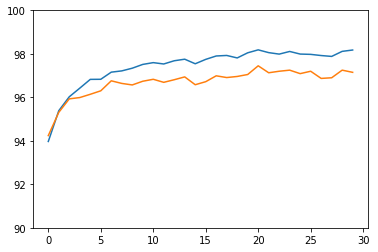

Target  : [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
Predict : [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
29


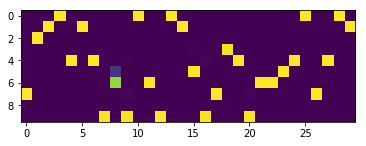

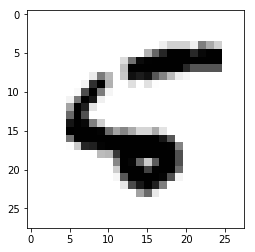

In [30]:
import pickle, gzip
import numpy as np
import matplotlib.pyplot as plt

#--------------------------------------------------------------------
# activation functions
# 활성함수의 함수값을 계산하는 함수와 미분값을 계산하는 함수를 한쌍으로 정의
# 'f'와 'df' 키워드로 묶음
def sigmoid(z):
    """
    Args:
        z : (C, N), C:클래스 수, N:샘플 수 이하 동일
    """
    return 1.0/(1.0+np.exp(-z))
 
def sigmoid_prime(z, y):
    """
    Args:
        z : (C, N)
        y : dummy
    
    [참고]
    여기서는 정답 벡터 y가 필요없지만 softmax_prime_with_crossent과 인터페이스를 맞추기 위해
    더미로 y를 넘겨 받음 None로 넘겨주면 됨.
    """ 
    return sigmoid(z)*(1-sigmoid(z))

Sigmoid = { 'f': sigmoid, 'df': sigmoid_prime }

def softmax(z):
    """
    Args:
        z : (C, N)
    
    [참고]
    max값을 빼서 언더플로 방지함.
    """
    z = z - np.max(z, axis=0) #max함수는 elmenet wise하게 작동하지 않기 때문에 axis을 지정해야함.
    return np.exp(z) / np.sum(np.exp(z), axis=0)

def softmax_prime(z, y):
    """
    Args:
        z : (C, N)
        y : dummy
    
    [참고]
    실제 softmax 함수 미분을 그대로 구현한것 
    미분 결과는 샘플 하나당 (C,C) 행렬이 되어 전체 결과는 (N,C,C)의 텐서
    보통은 softmax함수와 cross entropy를 함께 쓰므로 둘의 미분 곱해진 결과만 delta로 코딩을 함.
    굳이 미분을 코딩한다 하더라도 둘의 곱이 간단히 Hadamard곱이 될 수 있도록
    행렬로 정리해서 되돌리는 구현을 함. 그렇게 구현한 함수가 
    아래 softmax_prime_with_crossent 임.
    
    여기서는 학습의 목적으로 미분 그대로를 다 구현했음.
    """
    C, N = z.shape
    di = np.diag_indices(C)
    
    a = softmax(z) # a : (C,N)
    da = -np.einsum('ij,jk->jik', a, a.T)  #da :(N,C,C)
    da[:,di[0],di[1]] = (a*(1-a)).T
    
    return da

def softmax_prime_with_crossent(z, y):
    """
    Args:
        z : (C, N)
        y : col major로 인코딩된 one hot (C, N)
    
    [참고]
    이 함수는 softmax_prime의 주석에서 설명한것처럼 결과를 행렬로 만들어 되돌리는 축약형
    이 함수의 구현은 Cross Entropy 코스트와 함께 사용하도록 하기 위한 것으로 결과가 텐서
    가 아니라 행렬이 되도록 구현하였음. 이렇게 구현하면 Sigmoid-Mse 를 쓴 구성과 마찬가지로 
    출력층의 델터를 구하는 코드가 코스트의 미분 행렬(일반적으로 샘플이 여러개일때 코스트
    의미분은 행렬이 됨) * 출력층 활성함수의 미분 행렬로 동일하게 됨. 
    실제 Cross Entropy-Softmax일 경우는 벡터*행렬이 됨.
    일반적으로 구현하여 텐서를 되돌리는 softmax_prime함수를 쓰면 코스트의 미분과 출력층 
    활성함수의 미분을 곱하는 곳에서 행렬 * 텐서가 되서 적당히 알아서 곱해야 해야함.
    """    
    C, N = z.shape
    y_label = np.where(y.T==1)[1] #one-hot decoding , col major라서 전치후 where 적용
    
    #정답 위치를 알아아됨
    a = softmax(z) # a : (C,N)
    a_t = a[y_label, np.arange(N)].reshape(-1,1) #(N,1)
    
    #da/dz
    da = -a_t * a.T   #dz : (N,1)*(N,C)= (N,C)
    da[np.arange(N), y_label] = a_t.T * (1- a_t.T)
    return da.T # (C,N)
    
Softmax = {'f':softmax, 'df':softmax_prime }
#Softmax = {'f':softmax, 'df':softmax_prime_with_crossent }

def relu(z):
    """
    Args:
        z : (C, N)
    """
    return np.maximum(0, z) #maximum 함수는 element wise로 작동을 함.

def relu_prime(z, y):
    """
    Args:
        z : (C, N)
        y : dummy
    """
    #da/dz
    da = np.zeros(z.shape)
    da[z >= 0] = 1
    return da

Relu = {'f':relu, 'df':relu_prime }


#--------------------------------------------------------------------
# Cost function
# 목적함수의 함수값을 계산하는 함수와 미분값을 계산하는 함수를 한쌍으로 정의
# 'f'와 'df' 키워드로 묶음
def mse_cost(a, y):
    """
    Args:
        a : (C, N)
        y : col major로 인코딩된 one hot (C, N)
    """
    return 0.5*np.linalg.norm(a-y)**2

def mse_cost_prime(a, y):
    """
    Args:
        a : (C, N)
        y : col major로 인코딩된 one hot (C, N)
    """
    return (a-y)

Mse = {'f':mse_cost, 'df':mse_cost_prime}

def bin_cross_entropy_cost(a, y):
    """
    Args:
        a : (C, N)
        y : col major로 인코딩된 one hot (C, N)
    
    [참고]
    C = \sum_{j} -[y_j*log(a_j)+(1-y_j)*log(1-a_y)]
    j는 출력층 뉴런의 Index , mini-batch전체에 대해서 평균내는 부분은 없음
    """
    return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

def bin_cross_entropy_cost_prime(a, y):    
    """ 
    Args:
        a : (C, N)
        y : col major로 인코딩된 one hot (C, N)
    
    [참고]
    http://neuralnetworksanddeeplearning.com/chap3.html 의 Problem에 이 함수와 관련된 문제가 있음
    분모의 a(네트워크의 활성값)이 1 근처로 가면 0으로 나누는 것과 같은 문제가 
    발생할 가능성 있음.
    return (a-y) / (a*(1-a)) 이렇게 하면 실제로 오버플로 일어남.
    
    출력증의 델타는 delta^{L} = dC/da * da/dz 인데 
    결국 이 미분이 sigmoid의 미분과 곱해지면 분모가 약분되어 사라지면서 
    a-y가 delta가 됨. 그래서 delta를 바로 코딩하는 방식을 주로 사용. 
    그럼 오버플로문제도 없어짐
    이 코스트함수는 그렇게 sigmoid와 함께 사용하도록 의도적으로 설계된 함수임.
    
    여기서는 학습의 목적으로 미분을 그대로 다 구현했기 때문에 이 함수를 softmax와
    조합해서 사용하는 것도 가능함.
    https://www.reddit.com/r/MachineLearning/comments/39bo7k/can_softmax_be_used_with_cross_entropy/?st=j51xzboh&sh=1743ac2e
    위 레딧 링크에서는 안된다하는데 딱히 안될건 없어보이는데... 결과도 괜찮게 나옴
    """
    denom = (a*(1-a))
    denom[np.where(denom<np.finfo(np.float32).eps)] = np.finfo(np.float32).eps
    
    return (a-y) / denom 

BinCrossEnt = {'f':bin_cross_entropy_cost, 'df':bin_cross_entropy_cost_prime}

def cross_entropy_cost(a, y):
    """
    Args:
        a : (C, N)
        y : col major로 인코딩된 one hot (C, N)
    
    [참고]
    C = \sum_{k} y_k log(a_k)
    """
    return np.sum(np.nan_to_num(-y*np.log(a)))

def cross_entropy_cost_prime(a, y):
    """
    Args:
        a : (C, N)
        y : col major로 인코딩된 one hot (C, N)
    
    [참고]
    미분해서 행렬로 그대로 되돌리는 함수
    벡터로 되돌리는 함수는 cross_entropy_cost_prime_with_softmax 참조
    
    사실 bin_cross_entropy_cost_prime함수 주석에서 설명한것과 마찬가지 이유로
    이 코스트 함수가 softmax와 함께 쓰이면 delta가 결국 또 a-y가 되므로 delta를
    바로 코딩하는 것이 맞음.
    하지만 역시나 학습의 목적으로 따로 다 구현해서 조합해서 쓰는 식으로 했음.
    """
    dC = np.zeros(a.shape)
    a[np.where(a<np.finfo(np.float32).eps)] = np.finfo(np.float32).eps
    dC[np.where(y ==1)] = -y[np.where(y==1)]/a[np.where(y==1)]
    
    return dC  #(C,N)
    
def cross_entropy_cost_prime_with_softmax(a, y):
    """
    Args:
        a : (C, N)
        y : col major로 인코딩된 one hot (C, N)
    
    [참고]
    이 함수는 미분 결과를 벡터로 만들어 되돌리는 축약형
    원래 샘플 개수가 1개이상이면 코스트의 미분은 행렬이 되는데...
    크로스엔트로피 함수는 출력 a로 미분을 하면 정답위치만 값이 있고 나머지 자리는 모두 0
    그래서 행렬의 각 열에 값이 있는 부분만 모아서 벡터로 만들어 되돌림 
    이렇게 하면 softmax와 함께 쓰일 경우 출력층 델타를 효율적으로 계산할 수 있음.
    """  
    y_label = np.where(y.T==1)[1]
    a_t = a[y_label, np.arange(y.shape[1])].reshape(-1,1) #(N,1)
    a_t[np.where(a_t<np.finfo(np.float32).eps)] = np.finfo(np.float32).eps
    
    dC = -1/a_t  # dC : (N,1), a_t의 요소값이 너무 작으면 여기서 오버플로일어남. eps써서 막음
    return dC.T # (1,N)

CrossEnt = {'f':cross_entropy_cost, 'df':cross_entropy_cost_prime}
#CrossEnt = {'f':cross_entropy_cost, 'df':cross_entropy_cost_prime_with_softmax}

#--------------------------------------------------------------------
# Aux function
def one_hot_vector(y):
    Y = np.zeros((10, y.shape[0]))   #column major 
    Y[y.T, np.arange(y.shape[0])] = 1
    return Y

#--------------------------------------------------------------------    
# data load
f = gzip.open('mnist.pkl.gz', 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='iso-8859-1')
f.close()
X_train = training_data[0].reshape(50000,784).T   # column major data
Y_train = training_data[1].reshape(50000,1)       
X_valid = validation_data[0].reshape(10000,784).T # column major data
Y_valid = validation_data[1].reshape(10000,1)
X_test = test_data[0].reshape(10000,784).T  # column major data    
Y_test = test_data[1].reshape(10000,1)

#--------------------------------------------------------------------
# Class
class Network(object):
    """
    네트워크 Layer 및 Index 관계
    
                 O
                 O
                 O       O
                 O       O       O
                 O       O       O
                 O       O       O
                 O       O       O
                 O       O     
                 O
                 O
    
    layer index  0       1       2
    ------------------------------
    변수
    A       [   a0      a1      a2 ] : forward시 레이어의 활성값을 보관하여 backward시 활용
    Z       [ None      z1      z2 ] : forward시 레이어의 가중합을 보관하여 backward시 활용
    W       [ None      w1      w2 ] : weight 행렬을 저장하는 리스트
    dW      [ None     dw1     dw2 ] : weight에 대한 그래디언트를 저장하는 리스트
    B       [ None      b1      b2 ] : bias 벡터를 저장하는 리스트
    dB      [ None     db1     db2 ] : bias에 대한 그래디언트를 저장하는 리스트
    
    l 과 l+1을 연결하는 w에 대한 인덱스는 뒤쪽 l+1를 부여, 
    그래야 수식하고 프로그램 인덱스가 딱맞음
    인덱스를 맞추기 위해 첫번째 엘리먼트는 None을 부여
    """
    def __init__(self, sizes, activates, cost, w_init=None ):
        self.sizes = sizes
        self.activates = activates
        self.cost = cost
        
        # Parameters
        if w_init == 'Xavier' :
            self.W  = [None]+[np.random.randn(y, x)*np.sqrt(1/x) for x, y in zip(sizes[:-1], sizes[1:])]
        elif w_init == 'He' :
            self.W  = [None]+[np.random.randn(y, x)*np.sqrt(2/x) for x, y in zip(sizes[:-1], sizes[1:])]
        else :
            self.W  = [None]+[np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
            
        self.B  = [None]+[np.random.randn(y,1) for y in sizes[1:]] 
        self.m = 0
        self.eta = 0.01
               
    def pred(self, a):
        """
        학습 종료 후 예측 시 forward pass를 위한 함수
        """
        for l in range( 1, len(self.sizes) ) :
            #여기서는 dropuout 비율만큼 삭감해주어야 함.
            a = self.activates[l]['f']( (1-self.p_dropouts[l-1])*np.dot(self.W[l], a)+self.B[l] )
        return a    

    def forward(self, a):
        """
        학습시 forward pass 를 위한 함수
        """
        self.Z = [ None, ]
        self.A = [ a, ]
        self.mask = [ None, ]
        for l in range( 1, len(sizes) ) :
            """
            바이어스를 더할 때 주의 해야함. W:[nda(30,784), nad(10,30)]
            w:nda(30,784), a:nda(784,)  이면 두개를 dot하면 nda(30,) 가 됨
            w:nda(30,784), a:nda(784,1) 이면 두개를 dot하면 nda(30,1)가 됨
            nda(30,)+b:nda(30,1) 하면 브로드캐스팅이 됨 
            nda(30,1)+b:nda(30,1) 하면 nda(30,1)이 정상적으로 수행됨
            반대로 nda(30,1)+b:nda(30,) 하면 또 브로드캐스팅 됨.
            numpy 1차원 어레이에 행, 열 개념이 없어서 발생하는 문제..
            결국 엄격하게 벡터의 칼럼과 로우를 구별할지 말지 결정해야함.
            여기서는 벡터는 무조건 칼럼으로 구분하는 것으로 함. 
            """
            z = np.dot(self.W[l], a)+self.B[l]
            a = self.activates[l]['f'](z)
            
            mask = np.random.binomial(n=1, p=1-self.p_dropouts[l], size=a.shape)
            self.mask.append(mask)
            a = mask*a
            
            self.Z.append(z)
            self.A.append(a)
        
    def backward(self, y):
        self.dB    = [ None for i in range(len(sizes)) ]
        self.dW    = [ None for i in range(len(sizes)) ]
                
        Y = one_hot_vector(y)
        L = len(sizes)-1
        
        for l in range(L, 0, -1) :
            if l == L : #for delta^{L}
                """
                출력 층 델타를 위해서 ∂C/∂a 와 ∂a/∂z를 Hadamard 곱을하게 되는데
                이는 코스트함수와 출력층 활성함수가 모두 스칼라 함수일 때 가능한 방법임.
                코스트 함수는 다변수 스칼라 함수가 되지만 출력층 활성화함수는 softmax같이 다변수 벡터함수가
                될 수 있기 때문에 일률적으로 numpy 브로트캐스팅을 써서 곱하는 코드를 쓸 수 없음.
                물론 Softmax-CrossEnt 를 쓰는 경우 미분 결과를 잘 정비해서 ∂C/∂a도 행렬, ∂a/∂z도 행렬로
                만들어 주면 그냥 아래와 같은 하나의 코드로 구현 가능함.
                
                δ^{L} =       ∂C/∂a                 *              ∂a/∂z
                delta  = self.cost['df'](self.A[l], Y) * self.activates[l]['df'](self.Z[l], Y)
                
                그렇게 구현한 함수가 
                cross_entropy_cost_prime_with_softmax, softmax_prime_with_crossent 들임.
                
                그래서 출력층 델타를 구하는 코드를 일반적으로 만들기 위해서는 미분된 두항이 
                행렬인지 텐서인지 검사해서 적절히 곱해주도록 해야함.
                """
                dC , da = self.cost['df'](self.A[l], Y) , self.activates[l]['df'](self.Z[l], Y)
                
                if dC.shape == da.shape :
                    delta = dC * da #∂C/∂a, ∂a/∂z 둘 모양이 같으면 그냥 Hadamard 곱, 결과:(C,N)
                else :
                    delta = np.einsum('ij,jik->jk', dC, da).T  #모양이 다르면 einsum 으로 곱, 결과:(C,N)
            else : #for delta^{l}
                delta = np.dot(self.W[l+1].T, delta)  * self.activates[l]['df'](self.Z[l], Y)
                delta = delta*self.mask[l] # 포워드에서 저장해둔 드랍아웃 마스크를 곱한다.
          
            self.dB[l] = delta.sum(axis=1).reshape(-1,1)
            self.dW[l] = np.dot(delta, self.A[l-1].T)
    
    def update(self):
        self.W = [None] + [ (1-self.eta*(self.lmbda/self.n))*w-(self.eta/self.m)*nw for w, nw in zip(self.W[1:], self.dW[1:]) ]
        self.B = [None] + [ b - (self.eta/self.m)*db for b, db in zip(self.B[1:], self.dB[1:]) ]
                
    def train(self, X, Y, epochs, mini_batch_size, learning_rate,  p_dropouts, lmbda=0.0, X_test=None, Y_test=None):
        self.n = X.shape[1]          # 학습데이터 개수 
        self.m = mini_batch_size     # 미니배치 크게
        self.eta = learning_rate     # 학습률
        self.p_dropouts = p_dropouts # 드랍아웃 퍼센티지
        self.lmbda = lmbda           # 레귤러라이제이션 파라메터
        
        XY  = np.vstack((X, Y.T)).T  # shuffle을 위해 row major상태를 만든다.
        train_acc, test_acc = [], []
        
        for j in range(epochs):
            np.random.shuffle(XY) #row 를 섞어 버린다.
            mini_batches = [ XY[k:k+mini_batch_size] for k in range(0, self.n, mini_batch_size) ]
        
            for mini_batch in mini_batches:
                mini_batch_X, mini_batch_Y = np.vsplit(mini_batch.T, np.array([-1])) #row major->col major, 정답인 마지막 행을 잘라 낸다.
                mini_batch_Y = mini_batch_Y.T.astype(int) #잘려진 마지막 행은 다시 열로 바꾼다.
                
                self.forward(mini_batch_X)   
                self.backward(mini_batch_Y)  
                self.update()                
            
            if X_test is not None and Y_test is not None:
                train_acc.append(self.evaluate(X, Y)/self.n*100)
                test_acc.append(self.evaluate(X_test, Y_test)/Y_test.shape[0]*100)
                print("EPOCH:{:02d} Train Acc. : {:f}, Test Acc. : {:f}".format(j+1, train_acc[-1], test_acc[-1]))
        
        #plot acc
        plt.plot(train_acc)
        plt.plot(test_acc)
        plt.ylim(90, 100)
        plt.show()
        
    def evaluate(self, X_test, Y_test):
        pred = np.argmax( self.pred(X_test), axis=0 )
        return (pred.reshape(-1,1) == Y_test).sum()
    
#--------------------------------------------------------------------
# TEST
# Layers    적당히 리스트에 숫자를 적어주면 됨 
sizes =     [784,    100,       10]

# Activation functions 각층에 할당되는 활성화 함수를 적어줌
activates = [None,  Relu, Softmax]

#dropouts 각층에 할당되는 drop out rate로 뉴런을 꺼버릴 비율을 나타낸다.
p_dropouts  = [0.0, 0.5, 0.0]

Net = Network(sizes, activates, CrossEnt, 'He')
Net.train(X_train, Y_train, epochs=30, mini_batch_size=10, learning_rate=0.1, p_dropouts=p_dropouts, lmbda=5.0, X_test=X_test, Y_test=Y_test)

a = Net.pred(X_test[:,:30])
pred = np.argmax(a, axis=0)
print("Target  : {}".format(Y_test[:30].T[0]))
print("Predict : {}".format(pred))
comp = pred.reshape(-1,1) == Y_test[:30]
print(comp.sum())
errors = np.where(comp == False)[0]
plt.imshow(a)
plt.show()

#error rendering
for err in errors :
    x = X_test[:,:30][:,err]
    x = x.reshape(28,28)
    plt.imshow(x, cmap='gray_r')
    plt.show()
    

|    Layers    | Actvations |    Cost     | Epoches | Mini-batch | Leanrning rate | Test Acc.  | etc |
|--------------|------------|-------------|---------|------------|----------------|-------|-----|
| [784 150 60 10] | Relu, Relu, Softmax      | CrossEnt | 60      |   25       | 0.18            | 98.50 |Xavier, reg. $\lambda=6.0$, max. at epoch 29 |
| [784 150 60 10] | Relu, Relu, Softmax      | BinCrossEnt | 60      |   20       | 0.14            | 98.11 |Xavier, reg. $\lambda=5.2$, max. at epoch 40 |
| [784 150 60 10] | Relu, Relu, Softmax      | CrossEnt | 60      |   20       | 0.14            | 98.45 |Xavier, reg. $\lambda=5.2$, max. at epoch 40 |
| [784 150 60 10] | Relu, Relu, Softmax      | CrossEnt | 60      |   20       | 0.15            | 98.43 |Xavier, reg. $\lambda=5.5$, max. at epoch 56 |
| [784 150 60 10] | Relu, Relu, Softmax      | CrossEnt | 60      |   20       | 0.15            | 98.43 |Xavier, reg. $\lambda=5.0$, max. at epoch 45 |
| [784 150 60 10] | Sigmoid, Sigmoid, Softmax      | CrossEnt | 60      |   20       | 0.5            | 98.24 |Xavier, reg. $\lambda=5.0$, max. at epoch 36 |
| [784 100 10] | Sigmoid, Softmax      | CrossEnt | 60      |   5       | 0.1            | 98.10 |Xavier, reg. $\lambda=5.0$, max. at epoch 58 |
| [784 100 10] | Sigmoid, Softmax      | CrossEnt | 60      |   20       | 0.5            | 98.05 |Xavier, reg. $\lambda=5.0$, max. at epoch 33 |
| [784 100 10] | Sigmoid, Softmax      | CrossEnt | 60      |   20       | 0.5            | 97.80 |Xavier, max. at epoch 23 |
| [784 100 10] | Sigmoid, Softmax      | BinCrossEnt | 60      |   5       | 0.1            | 98.13 |Xavier, reg. $\lambda=5.0$, max. at 55 epoch |
| [784 100 10] | Sigmoid, Sigmoid      | BinCrossEnt | 60      |   5       | 0.1            | 98.06 |Xavier, reg. $\lambda=5.0$, max. at 45 epoch |
| [784 100 10] | Sigmoid, Sigmoid      | BinCrossEnt | 60      |   20       | 0.5            | 97.92 |Xavier, max. at epoch 39, |
| [784 100 10] | Sigmoid, Sigmoid      | Mse         | 60      |   20       | 3              | 98.04 |Xavier, max. at epoch 45 |



이상으로 간단한 네트워크를 작성해보았다. 애초에 의도했던대로 Numpy로만 150줄내외에서 (주석지우고 softmax, cross entropy 축약버전, 그림 그리는 코드, 마지막 테스트 코드 제외하면 165줄;;;;) 구현 요구사항을 만족시키도록 작성했다.


In [1]:
%%html
<link href='https://fonts.googleapis.com/earlyaccess/nanummyeongjo.css' rel='stylesheet' type='text/css'>
<link href='http://fonts.googleapis.com/earlyaccess/nanumgothiccoding.css' rel='stylesheet' type='text/css'>
<style>
    p  { font-family: 'Nanum Myeongjo'; font-size: 12pt; line-height: 200%;  text-indent: 10px; }
    li { font-family: 'Nanum Myeongjo'; font-size: 12pt; line-height: 200%; }
    li > p { text-indent: 0px; }
    
    .code-body { font-family: 'Nanum Gothic Coding', serif; }
    
    code, highlight { font-family: 'Nanum Gothic Coding', serif; }
</style>